## Download CAM set from Audit Analytics data from WRDS
* For Large-accelerated filers (LAFs): CAM is effective for audits of fiscal years ending on or after <b>June 30, 2019</b>.
* For the others: CAM is effective for audits of fiscal years ending on or after <b>Dec. 15, 2020</b>.
* Audit Analytics CAM data doesn't include date information. It can be obtained from Audit Opinion data.
* See for the regulatory details: https://pcaobus.org/oversight/standards/auditing-standards/details/AS3101


-------------------------

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import wrds
import matplotlib.pyplot as plt
pd.options.display.max_columns=200

-------------

### Connect WRDS

In [2]:
conn=wrds.Connection()

Enter your WRDS username [yjaey]: yjaeyoon
Enter your password: ···············


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
Loading library list...
Done


-----------

## Download data: CAM, Audit Opinions, Client info

In [3]:
# Audit Analytics dataSets to load 

aa_opin=    "audit.auditopin"
aa_company= "audit.auditcblock"
aa_cam=     "feed78_critical_audit_matter"

### Get CAM

In [4]:
cam= conn.get_table(library='audit', table=aa_cam)
print(cam.shape)
cam.head(2)

(21146, 11)


,description,response,title,critical_audit_matter_key,reference,critical_audit_matter_topic_fkey,topic_name,audit_opinion_fkey,auditor_fkey,company_fkey,best_edgar_ticker
0,As discussed in Note 1 to the consolidated fin...,The following are the primary procedures we pe...,Assessment of the write-down of inventories,12414.0,Note 1,45.0,Inventory,460559.0,4.0,0000001750,AIR
1,As discussed in Note 1 to the consolidated fin...,The following are the primary procedures we pe...,Evaluation of the estimate of costs at complet...,12415.0,Note 1,61.0,Revenue from customer contracts,460559.0,4.0,0000001750,AIR


In [5]:
cam.rename(columns={'description':'desc',
                  'response':'resp',
                  'critical_audit_matter_key':'cam_key',
                  'reference':'ref',
                  'critical_audit_matter_topic_fkey':'cam_topic_key',
                  'audit_opinion_fkey':'audit_op_key',
                  'auditor_fkey':'afk',
                  'company_fkey':'cik',
                  'best_edgar_ticker':'tic'}, inplace= True)
cam.head(2)

,desc,resp,title,cam_key,ref,cam_topic_key,topic_name,audit_op_key,afk,cik,tic
0,As discussed in Note 1 to the consolidated fin...,The following are the primary procedures we pe...,Assessment of the write-down of inventories,12414.0,Note 1,45.0,Inventory,460559.0,4.0,0000001750,AIR
1,As discussed in Note 1 to the consolidated fin...,The following are the primary procedures we pe...,Evaluation of the estimate of costs at complet...,12415.0,Note 1,61.0,Revenue from customer contracts,460559.0,4.0,0000001750,AIR


### Get auditopin + client info

In [6]:
auditop=conn.raw_sql(f"""select 
                        b.name,
                        b.sic_code_fkey as sic,
                        a.fiscal_year_of_op,
                        a.fiscal_year_end_op,
                        a.audit_op_key
                            
                from {aa_opin} a, {aa_company} b 
                where a.fiscal_year_of_op >= 2019 and a.company_fkey= b.company_fkey""")
print(auditop.shape)
auditop.head(2)

(39933, 5)


,name,sic,fiscal_year_of_op,fiscal_year_end_op,audit_op_key
0,AAR CORP,3720,2019.0,2019-05-31,407089.0
1,AAR CORP,3720,2020.0,2020-05-31,429723.0


--------------

## Merge data - at the <em>firm-cam-year</em> level

In [7]:
df= cam.merge(right= auditop, on= 'audit_op_key')
print(df.shape)
df.head(2)

(17648, 15)


,desc,resp,title,cam_key,ref,cam_topic_key,topic_name,audit_op_key,afk,cik,tic,name,sic,fiscal_year_of_op,fiscal_year_end_op
0,As discussed in Note 1 to the consolidated fin...,The following are the primary procedures we pe...,Assessment of the write-down of inventories,12414.0,Note 1,45.0,Inventory,460559.0,4.0,0000001750,AIR,AAR CORP,3720,2021.0,2021-05-31
1,As discussed in Note 1 to the consolidated fin...,The following are the primary procedures we pe...,Evaluation of the estimate of costs at complet...,12415.0,Note 1,61.0,Revenue from customer contracts,460559.0,4.0,0000001750,AIR,AAR CORP,3720,2021.0,2021-05-31


In [8]:
df.nunique()

desc                  17133
resp                  16188
title                  9883
cam_key               17648
ref                    2338
cam_topic_key            56
topic_name               56
audit_op_key          11975
afk                     244
cik                    5588
tic                    4842
name                   5588
sic                     396
fiscal_year_of_op         4
fiscal_year_end_op      160
dtype: int64

In [9]:
df['y']= pd.to_datetime(df['fiscal_year_end_op']).dt.year
df['m']= pd.to_datetime(df['fiscal_year_end_op']).dt.month
df['fy']=df['y']
df.loc[df['m']<=5, 'fy']= df['y']-1
df.head(2)

,desc,resp,title,cam_key,ref,cam_topic_key,topic_name,audit_op_key,afk,cik,tic,name,sic,fiscal_year_of_op,fiscal_year_end_op,y,m,fy
0,As discussed in Note 1 to the consolidated fin...,The following are the primary procedures we pe...,Assessment of the write-down of inventories,12414.0,Note 1,45.0,Inventory,460559.0,4.0,0000001750,AIR,AAR CORP,3720,2021.0,2021-05-31,2021,5,2020
1,As discussed in Note 1 to the consolidated fin...,The following are the primary procedures we pe...,Evaluation of the estimate of costs at complet...,12415.0,Note 1,61.0,Revenue from customer contracts,460559.0,4.0,0000001750,AIR,AAR CORP,3720,2021.0,2021-05-31,2021,5,2020


----------------------

## Inspection with visualization

### Distribution of CAM topics

In [10]:
df_dist= df.groupby('topic_name').count()['cam_key'].sort_values(ascending=False).reset_index()
df_dist.head(20)

,topic_name,cam_key
0,Revenue from customer contracts,2215
1,Business combinations,1743
2,Goodwill,1656
3,Allowance for credit losses,1208
4,Other contingent liabilities,775
5,Inventory,664
6,Other investments,606
7,Deferred income taxes,524
8,Long-lived assets,517
9,Other intangible assets,503


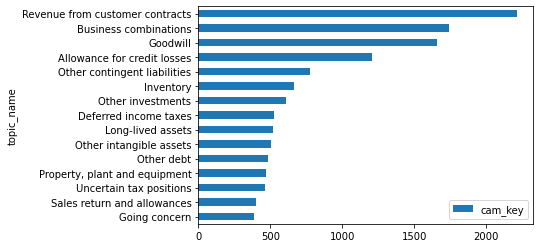

In [15]:
df_dist_top15= df_dist.head(15).sort_values('cam_key', ascending= True)
df_dist_top15.plot(kind='barh', x= 'topic_name', y= 'cam_key')
plt.show()

### How many CAM keys per each audit report?

In [16]:
df_cam_n= pd.DataFrame(df.groupby('audit_op_key').agg({'cam_topic_key':'count'}).value_counts()).reset_index().rename(columns={'cam_topic_key':'cam_N', 0:'N'})
df_cam_n['cam_N']= df_cam_n['cam_N'].astype('str')
df_cam_n

,cam_N,N
0,1,7663
1,2,3219
2,3,871
3,4,188
4,5,25
5,6,6
6,7,3


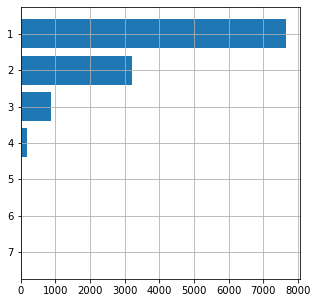

In [19]:
df_cam_n.cam_N= df_cam_n.cam_N.astype('str')
df_cam_n.sort_values('cam_N', ascending= False, inplace= True)
fig=plt.figure(figsize=(5,5))
plt.grid()
plt.barh(df_cam_n.cam_N, df_cam_n.N)
plt.show()

### Yearly distribution of unique firms

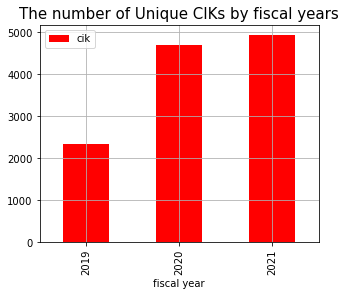

In [11]:
df[['cik','fy']].groupby('fy').nunique('cik').plot(kind='bar', figsize=(5,4), grid= True, color='red')
plt.title('The number of Unique CIKs by fiscal years', fontsize= 15)
plt.xlabel('fiscal year')
plt.show()

### Yearly distribution of CAMs

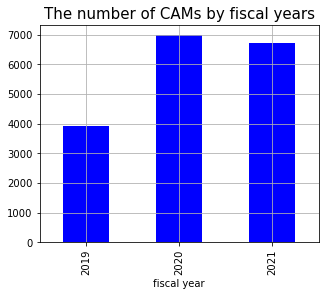

In [12]:
df.groupby(['fy']).size().plot(kind='bar', figsize=(5,4), grid= True, color= 'b')
plt.title('The number of CAMs by fiscal years', fontsize= 15)
plt.xlabel('fiscal year')
plt.show()

<b>Note</b>: One company may have more than one CAM.

-----------

### Close connection

In [13]:
conn.close()

-------------